In [2]:
# imports -- change ip and fingerprint between hosts
import pandas as pd
import pyexasol

host = '192.168.56.102/DC90C14858BD2A0A3FE10C5245C4032AF3E179041AB66687CF4E8430A7FC94EE:8563'   # Don't forget to change the fingerprint
user = 'sys'
password = 'exasol'

# Connect to Exasol
conn = pyexasol.connect(dsn=host, 
                        user=user, 
                        password=password, 
                        debug=False, 
                        protocol_version=pyexasol.PROTOCOL_V1)

## top 10 keywords for each events (During their occurance)

In [320]:
QUERY='''
WITH queries AS (
    SELECT DISTINCT
        TIMEDIM.[month],
        TIMEDIM.[day of the month],
        TIMEDIM.[hour],
        TIMEDIM.[minute],
        QUERYDIM.QUERY,
        FACTS.ANONID,
        TO_TIMESTAMP(
            '2006-' || 
            LPAD(
                CASE 
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'january' THEN '01'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'february' THEN '02'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'march' THEN '03'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'april' THEN '04'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'may' THEN '05'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'june' THEN '06'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'july' THEN '07'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'august' THEN '08'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'september' THEN '09'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'october' THEN '10'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'november' THEN '11'
                    WHEN LOWER(TRIM(TIMEDIM.[month])) = 'december' THEN '12'
                    ELSE '00'
                END, 2, '0') || 
            '-' || 
            LPAD(CAST(TIMEDIM.[day of the month] AS VARCHAR(10)), 2, '0') || 
            ' ' ||
            LPAD(CAST(TIMEDIM.[hour] AS VARCHAR(2)), 2, '0') || ':' || 
            LPAD(CAST(TIMEDIM.[minute] AS VARCHAR(2)), 2, '0')
        ) AS formatted_date
    FROM AOL_SCHEMA.TIMEDIM
    LEFT JOIN AOL_SCHEMA.QUERYDIM ON QUERYDIM.ID = TIMEDIM.ID
    LEFT JOIN AOL_SCHEMA.FACTS ON FACTS.QUERYID = QUERYDIM.ID
    WHERE FACTS.CLICK = 1
    LIMIT 10
),
queries_events AS (
    SELECT
        queries.QUERY,
        we.EVENT_TYPE,
        COUNT(*) AS query_count
    FROM queries
    LEFT JOIN AOL_SCHEMA.WEATHER_EVENTS we
        ON queries.formatted_date BETWEEN we.BEGIN_DATE_TIME AND we.END_DATE_TIME
    GROUP BY GROUPING SETS (
        (queries.QUERY, we.EVENT_TYPE)
    )
),
keywords_with_counts AS (
    SELECT 
        REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num) AS KEYWORD,
        queries_events.EVENT_TYPE,
        SUM(queries_events.query_count) AS total_query_count
    FROM queries_events
    JOIN (
        SELECT LEVEL AS seq_num
        FROM DUAL
        CONNECT BY LEVEL <= 100
    ) seq
    ON REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num) IS NOT NULL
    WHERE LOWER(REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num)) NOT IN ('and', 'the', 'is', 'in', 'on', 'at', 'a', 'an')
    GROUP BY REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num), queries_events.EVENT_TYPE
),
ranked_keywords AS (
    SELECT 
        KEYWORD,
        EVENT_TYPE,
        total_query_count,
        RANK() OVER (PARTITION BY EVENT_TYPE ORDER BY total_query_count DESC) AS keyword_rank
    FROM keywords_with_counts
)
SELECT 
    KEYWORD,
    EVENT_TYPE,
    total_query_count,
    keyword_rank
FROM ranked_keywords
WHERE keyword_rank <= 10
ORDER BY EVENT_TYPE, keyword_rank;
'''
weather_events = conn.export_to_pandas(QUERY)
weather_events.head(3)

,KEYWORD,EVENT_TYPE,TOTAL_QUERY_COUNT,KEYWORD_RANK
0,sagamore,Debris Flow,6,1
1,baron,Debris Flow,5,2
2,cameron,Debris Flow,5,2


In [215]:
weather_events[weather_events['EVENT_TYPE']=='Flood']

,KEYWORD,EVENT_TYPE,TOTAL_QUERY_COUNT,KEYWORD_RANK
50,oven,Flood,35,1
51,potato,Flood,35,1
52,baked,Flood,35,1
53,iowa,Flood,32,4
54,paper,Flood,32,4
55,gazette,Flood,32,4
56,yarn,Flood,32,4
57,females,Flood,29,8
58,xxx,Flood,29,8
59,rated,Flood,29,8


In [214]:
np.unique(weather_events['EVENT_TYPE'])

array(['Blizzard', 'Debris Flow', 'Drought', 'Flash Flood', 'Flood',
       'Hail', 'Heat', 'Heavy Rain', 'Heavy Snow', 'High Surf',
       'High Wind', 'Strong Wind', 'Thunderstorm Wind', 'Wildfire',
       'Winter Storm', 'Winter Weather'], dtype=object)

In [385]:
Query='''
CREATE TABLE AOL_SCHEMA.Queries_new AS
SELECT DISTINCT
    TIMEDIM."month",
    TIMEDIM."day of the month",
    TIMEDIM."hour",
    TIMEDIM."minute",
    QUERYDIM."QUERY",
    FACTS."ANONID",
    TO_TIMESTAMP(
        '2006-' || 
        LPAD(
            CASE 
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'january' THEN '01'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'february' THEN '02'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'march' THEN '03'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'april' THEN '04'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'may' THEN '05'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'june' THEN '06'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'july' THEN '07'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'august' THEN '08'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'september' THEN '09'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'october' THEN '10'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'november' THEN '11'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'december' THEN '12'
                ELSE '00'
            END, 2, '0') || 
        '-' || 
        LPAD(CS.CLICK = 1
AST(TIMEDIM."day of the month" AS VARCHAR(10)), 2, '0') || 
        ' ' ||
        LPAD(CAST(TIMEDIM."hour" AS VARCHAR(2)), 2, '0') || ':' || 
        LPAD(CAST(TIMEDIM."minute" AS VARCHAR(2)), 2, '0')
    ) AS formatted_date
FROM AOL_SCHEMA."TIMEDIM"
INNER JOIN AOL_SCHEMA."QUERYDIM" ON QUERYDIM."ID" = TIMEDIM."ID"
INNER JOIN AOL_SCHEMA."FACTS" ON FACTS."QUERYID" = QUERYDIM."ID"
WHERE FACTS."CLICK" = 1
'''
conn.execute(Query)

ExaQueryError: 
(
    message     =>  object QUERIES_NEW already exists (Session: 1816259599984223860)
    dsn         =>  192.168.56.102/DC90C14858BD2A0A3FE10C5245C4032AF3E179041AB66687CF4E8430A7FC94EE:8563
    user        =>  sys
    schema      =>  
    session_id  =>  1816259599984223860
    code        =>  42500
    query       =>  CREATE TABLE AOL_SCHEMA.Queries_new AS
SELECT DISTINCT
    TIMEDIM."month",
    TIMEDIM."day of the month",
    TIMEDIM."hour",
    TIMEDIM."minute",
    QUERYDIM."QUERY",
    FACTS."ANONID",
    TO_TIMESTAMP(
        '2006-' || 
        LPAD(
            CASE 
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'january' THEN '01'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'february' THEN '02'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'march' THEN '03'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'april' THEN '04'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'may' THEN '05'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'june' THEN '06'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'july' THEN '07'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'august' THEN '08'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'september' THEN '09'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'october' THEN '10'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'november' THEN '11'
                WHEN LOWER(TRIM(TIMEDIM."month")) = 'december' THEN '12'
                ELSE '00'
            END, 2, '0') || 
        '-' || 
        LPAD(CAST(TIMEDIM."day of the month" AS VARCHAR(10)), 2, '0') || 
        ' ' ||
        LPAD(CAST(TIMEDIM."hour" AS VARCHAR(2)), 2, '0') || ':' || 
        LPAD(CAST(TIMEDIM."minute" AS VARCHAR(2)), 2, '0')
    ) AS formatted_date
FROM AOL_SCHEMA."TIMEDIM"
INNER JOIN AOL_SCHEMA."QUERYDIM" ON QUERYDIM."ID" = TIMEDIM."ID"
INNER JOIN AOL_SCHEMA."FACTS" ON FACTS."QUERYID" = QUERYDIM."ID"
WHERE FACTS."CLICK" = 1
)


In [3]:
import time

start_time = time.time()
QUERY='''
SELECT * FROM AOL_SCHEMA.Queries_new
LIMIT 10
'''
joined = conn.export_to_pandas(QUERY)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
joined.shape

Elapsed time: 1.3331780433654785 seconds


(10, 7)

In [409]:
QUERY_events='''
WITH EVENT_COUNTS AS (
    SELECT DISTINCT
        EVENT_TYPE,
        COUNT(*) AS occurrence_count
    FROM AOL_SCHEMA.WEATHER_EVENTS
    GROUP BY EVENT_TYPE
    ORDER BY occurrence_count DESC
    LIMIT 2
)
SELECT
    we.EVENT_TYPE,
    we.BEGIN_DATE_TIME,
    we.END_DATE_TIME
FROM AOL_SCHEMA.WEATHER_EVENTS we
INNER JOIN EVENT_COUNTS ec
    ON we.EVENT_TYPE = ec.EVENT_TYPE
ORDER BY we.EVENT_TYPE, we.BEGIN_DATE_TIME;
'''
events = conn.export_to_pandas(QUERY_events)

In [408]:
events

,EVENT_TYPE,BEGIN_DATE_TIME,END_DATE_TIME
0,Hail,2006-01-01 15:25:00.000000,2006-01-01 15:30:00.000000
1,Hail,2006-01-01 15:35:00.000000,2006-01-01 15:40:00.000000
2,Hail,2006-01-01 16:00:00.000000,2006-01-01 16:05:00.000000
3,Hail,2006-01-01 16:20:00.000000,2006-01-01 16:25:00.000000
4,Hail,2006-01-01 19:00:00.000000,2006-01-01 19:05:00.000000
...,...,...,...
9406,Hail,2006-05-31 19:40:00.000000,2006-05-31 19:45:00.000000
9407,Hail,2006-05-31 20:04:00.000000,2006-05-31 20:09:00.000000
9408,Hail,2006-05-31 20:20:00.000000,2006-05-31 20:25:00.000000
9409,Hail,2006-05-31 20:37:00.000000,2006-05-31 20:37:00.000000


In [419]:
start_time = time.time()

QUERY = '''
WITH EVENT_COUNTS AS (
    SELECT
        EVENT_TYPE,
        COUNT(*) AS occurrence_count
    FROM AOL_SCHEMA.WEATHER_EVENTS
    GROUP BY EVENT_TYPE
    ORDER BY occurrence_count DESC
    LIMIT 2
),
Events_DATA AS (
    SELECT
        we.EVENT_TYPE,
        we.BEGIN_DATE_TIME,
        we.END_DATE_TIME
    FROM AOL_SCHEMA.WEATHER_EVENTS we
    INNER JOIN EVENT_COUNTS ec
        ON we.EVENT_TYPE = ec.EVENT_TYPE
    ORDER BY we.EVENT_TYPE, we.BEGIN_DATE_TIME
),
queries_events AS (
    SELECT
        Queries_new.QUERY,
        we.EVENT_TYPE,
        COUNT(*) AS query_count
    FROM AOL_SCHEMA.Queries_new
    INNER JOIN Events_DATA we
        ON Queries_new.formatted_date BETWEEN we.BEGIN_DATE_TIME AND we.END_DATE_TIME
    GROUP BY GROUPING SETS (
        (Queries_new.QUERY, we.EVENT_TYPE)
    )
),
keywords_with_counts AS (
    SELECT 
        REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num) AS KEYWORD,
        queries_events.EVENT_TYPE,
        SUM(queries_events.query_count) AS total_query_count
    FROM queries_events
    CROSS JOIN (
        SELECT LEVEL AS seq_num
        FROM DUAL
        CONNECT BY LEVEL <= 100
    ) seq
    WHERE REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num) IS NOT NULL
      AND LOWER(REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num)) NOT IN ('and', 'the', 'is', 'in', 'on', 'at', 'a', 'an')
    GROUP BY REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num), queries_events.EVENT_TYPE
),
ranked_keywords AS (
    SELECT 
        KEYWORD,
        EVENT_TYPE,
        total_query_count,
        RANK() OVER (PARTITION BY EVENT_TYPE ORDER BY total_query_count DESC) AS keyword_rank
    FROM keywords_with_counts
)
SELECT 
    KEYWORD,
    EVENT_TYPE,
    total_query_count,
    keyword_rank
FROM ranked_keywords
WHERE keyword_rank <= 10
ORDER BY EVENT_TYPE, keyword_rank;
'''

# Execute the query and fetch the results
weather_events = conn.export_to_pandas(QUERY)

# End the timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Display results and elapsed time
print(weather_events.head(3))
print(f"Elapsed time: {elapsed_time} seconds")

ExaQueryAbortError: 
(
    message     =>  Client requested execution abort (Session: 1816263251595744863)
    dsn         =>  192.168.56.102/DC90C14858BD2A0A3FE10C5245C4032AF3E179041AB66687CF4E8430A7FC94EE:8563
    user        =>  sys
    schema      =>  
    session_id  =>  1816263251595744863
    code        =>  R0003
    query       =>  EXPORT (
WITH EVENT_COUNTS AS (
    SELECT
        EVENT_TYPE,
        COUNT(*) AS occurrence_count
    FROM AOL_SCHEMA.WEATHER_EVENTS
    GROUP BY EVENT_TYPE
    ORDER BY occurrence_count DESC
    LIMIT 2
),
Events_DATA AS (
    SELECT
        we.EVENT_TYPE,
        we.BEGIN_DATE_TIME,
        we.END_DATE_TIME
    FROM AOL_SCHEMA.WEATHER_EVENTS we
    INNER JOIN EVENT_COUNTS ec
        ON we.EVENT_TYPE = ec.EVENT_TYPE
    ORDER BY we.EVENT_TYPE, we.BEGIN_DATE_TIME
),
queries_events AS (
    SELECT
        Queries_new.QUERY,
        we.EVENT_TYPE,
        COUNT(*) AS query_count
    FROM AOL_SCHEMA.Queries_new
    INNER JOIN Events_DATA we
        ON Queries_new.formatted_date BETWEEN we.BEGIN_DATE_TIME AND we.END_DATE_TIME
    GROUP BY GROUPING SETS (
        (Queries_new.QUERY, we.EVENT_TYPE)
    )
),
keywords_with_counts AS (
    SELECT 
        REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num) AS KEYWORD,
        queries_events.EVENT_TYPE,
        SUM(queries_events.query_count) AS total_query_count
    FROM queries_events
    CROSS JOIN (
        SELECT LEVEL AS seq_num
        FROM DUAL
        CONNECT BY LEVEL <= 100
    ) seq
    WHERE REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num) IS NOT NULL
      AND LOWER(REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num)) NOT IN ('and', 'the', 'is', 'in', 'on', 'at', 'a', 'an')
    GROUP BY REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num), queries_events.EVENT_TYPE
),
ranked_keywords AS (
    SELECT 
        KEYWORD,
        EVENT_TYPE,
        total_query_count,
        RANK() OVER (PARTITION BY EVENT_TYPE ORDER BY total_query_count DESC) AS keyword_rank
    FROM keywords_with_counts
)
SELECT 
    KEYWORD,
    EVENT_TYPE,
    total_query_count,
    keyword_rank
FROM ranked_keywords
WHERE keyword_rank <= 10
ORDER BY EVENT_TYPE, keyword_rank
) INTO CSV
AT 'https://27.1.0.10:50418' FILE '000.csv'
WITH COLUMN NAMES
)


In [379]:
import time
import pandas as pd

# Start timing
start_time = time.time()

# Define the query
QUERY = '''
WITH WEATHER_DATA AS (
    SELECT DISTINCT
        EVENT_TYPE, 
        BEGIN_DATE_TIME, 
        END_DATE_TIME
    FROM AOL_SCHEMA.WEATHER_EVENTS
),
queries_events AS (
    SELECT
        Queries_new.QUERY,
        we.EVENT_TYPE,
        COUNT(*) AS query_count
    FROM AOL_SCHEMA.Queries_new
    LEFT JOIN WEATHER_DATA we
        ON Queries_new.formatted_date BETWEEN we.BEGIN_DATE_TIME AND we.END_DATE_TIME
    GROUP BY GROUPING SETS (
        (Queries_new.QUERY, we.EVENT_TYPE)
    )
),
keywords_with_counts AS (
    SELECT 
        REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num) AS KEYWORD,
        queries_events.EVENT_TYPE,
        SUM(queries_events.query_count) AS total_query_count
    FROM queries_events
    CROSS JOIN (
        SELECT LEVEL AS seq_num
        FROM DUAL
        CONNECT BY LEVEL <= 100
    ) seq
    WHERE REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num) IS NOT NULL
      AND LOWER(REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num)) NOT IN ('and', 'the', 'is', 'in', 'on', 'at', 'a', 'an')
    GROUP BY REGEXP_SUBSTR(queries_events.QUERY, '[^ ]+', 1, seq.seq_num), queries_events.EVENT_TYPE
),
ranked_keywords AS (
    SELECT 
        KEYWORD,
        EVENT_TYPE,
        total_query_count,
        RANK() OVER (PARTITION BY EVENT_TYPE ORDER BY total_query_count DESC) AS keyword_rank
    FROM keywords_with_counts
)
SELECT 
    KEYWORD,
    EVENT_TYPE,
    total_query_count,
    keyword_rank
FROM ranked_keywords
WHERE keyword_rank <= 10
ORDER BY EVENT_TYPE, keyword_rank;
'''

# Execute the query and fetch the results
weather_events = conn.export_to_pandas(QUERY)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

# Display results and elapsed time
print(weather_events.head(3))
print(f"Total elapsed time: {elapsed_time:.2f} seconds")

ExaConcurrencyError: 
(
    message     =>  Connection cannot be shared between multiple threads sending requests simultaneously
    dsn         =>  192.168.56.102/DC90C14858BD2A0A3FE10C5245C4032AF3E179041AB66687CF4E8430A7FC94EE:8563
    user        =>  sys
    schema      =>  
    session_id  =>  1816257394041281774
)


In [376]:
weather_events

,KEYWORD,EVENT_TYPE,TOTAL_QUERY_COUNT,KEYWORD_RANK
0,sagamore,Debris Flow,6,1
1,baron,Debris Flow,5,2
2,cameron,Debris Flow,5,2
3,registers,Debris Flow,1,4
4,floor,Debris Flow,1,4
...,...,...,...,...
69,tower,Winter Storm,1,1
70,selling,Winter Storm,1,1
71,site,Winter Storm,1,1
72,baron,Winter Weather,1,1


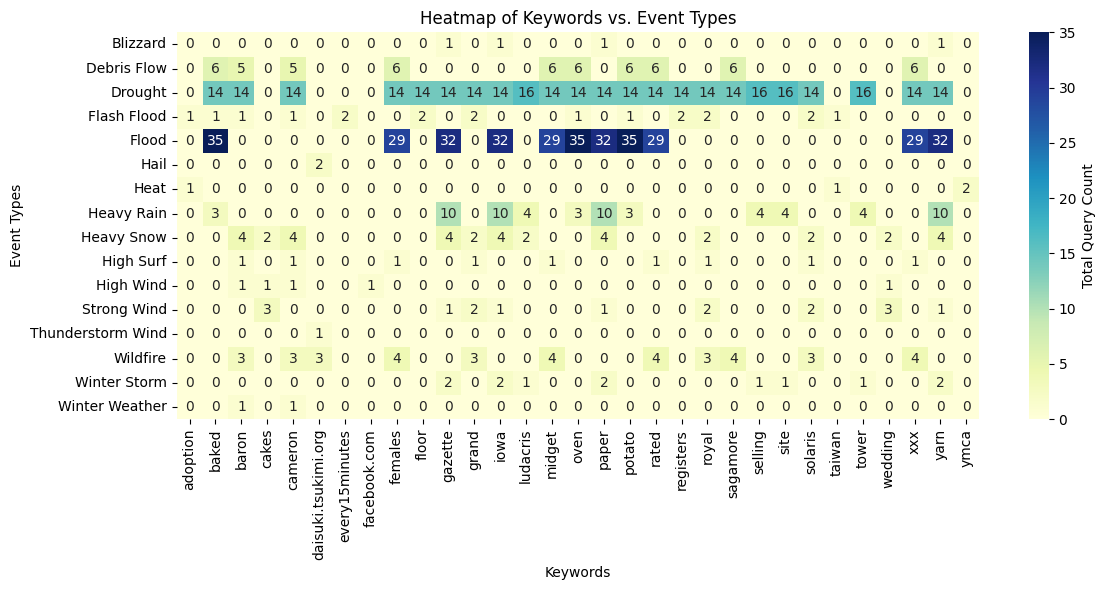

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Pivot table to create matrix of events vs. keywords
heatmap_data = weather_events.pivot_table(index='EVENT_TYPE', columns='KEYWORD', values='TOTAL_QUERY_COUNT', aggfunc='sum', fill_value=0)

# Plotting the Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt='g', cbar_kws={'label': 'Total Query Count'})

# Adding labels and title
plt.title('Heatmap of Keywords vs. Event Types')
plt.xlabel('Keywords')
plt.ylabel('Event Types')

# Show plot
plt.tight_layout()
plt.show()


In [496]:
import time
import pandas as pd

# Start timing
start_time = time.time()

# Define the corrected query
QUERY = '''
SELECT *
FROM AOL_SCHEMA.QUERYDIM
'''

# Execute the query and fetch results
query = conn.export_to_pandas(QUERY)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

# Display results and elapsed time
print(query.head(3))
print(f"Total elapsed time: {elapsed_time:.2f} seconds")


                          QUERY  ID
0              donate cars cash   1
1  cartwheels panthers allstars   2
2                        baders   3
Total elapsed time: 18.44 seconds


In [497]:
query

,QUERY,ID
0,donate cars cash,1
1,cartwheels panthers allstars,2
2,baders,3
3,toocool.com,4
4,wwwheartlandapp.com,5
...,...,...
10154737,'up front',10154738
10154738,grandview condos panama city,10154739
10154739,http holydays.tripod.com shamrock.htm,10154740
10154740,long island vital statistics,10154741


In [492]:
import time
import pandas as pd

# Start timing
start_time = time.time()

# Define the corrected query
QUERY = '''
WITH limited_querydim AS (
    SELECT DISTINCT QUERY
    FROM AOL_SCHEMA.QUERYDIM
    WHERE QUERY IS NOT NULL
    LIMIT 10
),
tokenized_query AS (
    SELECT 
        QUERY, 
        REGEXP_SUBSTR(QUERY, '[^ ]+', 1, LEVEL) AS TOKEN, 
        LEVEL AS TOKEN_POSITION
    FROM limited_querydim
    CONNECT BY PRIOR QUERY = QUERY
           AND PRIOR SYS_GUID() IS NOT NULL
           AND REGEXP_SUBSTR(QUERY, '[^ ]+', 1, LEVEL) IS NOT NULL
)
SELECT 
    QUERY, 
    TOKEN, 
    TOKEN_POSITION
FROM tokenized_query
ORDER BY QUERY, TOKEN_POSITION;
'''

# Execute the query and fetch results
query_results = conn.export_to_pandas(QUERY)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

# Display results and elapsed time
print(query_results.head(3))
print(f"Total elapsed time: {elapsed_time:.2f} seconds")


                        QUERY    TOKEN  TOKEN_POSITION
0  aa broward county meetings       aa               1
1  aa broward county meetings  broward               2
2  aa broward county meetings   county               3
Total elapsed time: 91.12 seconds


In [493]:
query_results.shape

(20, 3)

In [495]:
query_results

,QUERY,TOKEN,TOKEN_POSITION
0,aa broward county meetings,aa,1
1,aa broward county meetings,broward,2
2,aa broward county meetings,county,3
3,aa broward county meetings,meetings,4
4,baders,baders,1
5,cartwheels panthers allstars,cartwheels,1
6,cartwheels panthers allstars,panthers,2
7,cartwheels panthers allstars,allstars,3
8,donate cars cash,donate,1
9,donate cars cash,cars,2


In [466]:
query_results

,QUERY,KEYWORD
0,www.looneytonestickers.com,www.looneytonestickers.com
1,almendares,almendares
2,grapes ct,grapes
3,www.texaspension.com,www.texaspension.com
4,patriot computers finance department,patriot
5,grapes ct,ct
6,patriot computers finance department,computers
7,grapes ct,ct
8,patriot computers finance department,computers
9,grapes ct,ct


In [488]:
import time
import pandas as pd

# Start timing
start_time = time.time()

# Define the corrected query
QUERY = '''
WITH tokenized_query AS (
    SELECT 
        QUERY, 
        REGEXP_SUBSTR(QUERY, '[^ ]+', 1, LEVEL) AS TOKEN, 
        LEVEL AS TOKEN_POSITION
    FROM AOL_SCHEMA.QUERYDIM
    CONNECT BY PRIOR QUERY = QUERY
           AND PRIOR SYS_GUID() IS NOT NULL
           AND REGEXP_SUBSTR(QUERY, '[^ ]+', 1, LEVEL) IS NOT NULL
)
SELECT 
    QUERY, 
    TOKEN, 
    TOKEN_POSITION
FROM tokenized_query
ORDER BY QUERY, TOKEN_POSITION;

'''

# Execute the query and fetch results
query_results = conn.export_to_pandas(QUERY)

# End timing
end_time = time.time()
elapsed_time = end_time - start_time

# Display results and elapsed time
print(query_results.head(3))
print(f"Total elapsed time: {elapsed_time:.2f} seconds")


ExaQueryError: 
(
    message     =>  CONNECT BY primitives can only be used in CONNECT BY queries: LEVEL (Session: 1816304037019747674)
    dsn         =>  192.168.56.102/DC90C14858BD2A0A3FE10C5245C4032AF3E179041AB66687CF4E8430A7FC94EE:8563
    user        =>  sys
    schema      =>  
    session_id  =>  1816304037019747674
    code        =>  42000
    query       =>  EXPORT (
WITH limited_querydim AS (
    SELECT *
    FROM AOL_SCHEMA.QUERYDIM
    LEFT JOIN AOL_SCHEMA.FACTS ON FACTS.QUERYID = QUERYDIM.ID
    WHERE FACTS.CLICK = 1
    LIMIT 100
),
word_sequence AS (
    SELECT 
        QUERY,
        REGEXP_SUBSTR(QUERY, '[^ ]+', 1, LEVEL) AS KEYWORD,
        LEVEL AS word_position
    FROM limited_querydim
    WHERE REGEXP_SUBSTR(QUERY, '[^ ]+', 1, LEVEL) IS NOT NULL
)
SELECT 
    QUERY,
    KEYWORD
FROM word_sequence
WHERE LOWER(KEYWORD) NOT IN ('and', 'the', 'is', 'in', 'on', 'at', 'a', 'an')
) INTO CSV
AT 'https://27.1.0.10:48791' FILE '000.csv'
WITH COLUMN NAMES
)
